### Import the required libraries and modules:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/DRIVE2

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/DRIVE2


### Unzip the data:

In [ ]:
# !unzip new_data.zip

### Construct the Model:

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE



### Training the Model:

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model1.h5")
csv_path = os.path.join("files", "data1.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model1 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 384], strides=[1, 2, 2, 2])

model1.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 20 - 20
Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0570 - dice_coef: 0.3087 - iou: 0.1847 - recall: 0.5915 - precision: 0.4687
Epoch 1: val_loss improved from inf to 1.49777, saving model to files/model1.h5
35/35 [==============================] - 87s 2s/step - loss: 1.0570 - dice_coef: 0.3087 - iou: 0.1847 - recall: 0.5915 - precision: 0.4687 - val_loss: 1.4978 - val_dice_coef: 0.1459 - val_iou: 0.0787 - val_recall: 7.7532e-06 - val_precision: 1.9499e-04 - lr: 1.0000e-04
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.7583 - dice_coef: 0.4561 - iou: 0.2959 - recall: 0.6094 - precision: 0.7987
Epoch 2: val_loss improved from 1.49777 to 1.39146, saving model to files/model1.h5
35/35 [==============================] - 51s 1s/step - loss: 0.7583 - dice_coef: 0.4561 - iou: 0.2959 - recall: 0.6094 - precision: 0.7987 - val_loss: 1.3915 - val_dice_coef: 0.1382 - val_iou: 0.0742 - val_recall: 0.0000e+00 - val_precision: 

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model2.h5")
csv_path = os.path.join("files", "data2.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model2 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 512], strides=[1, 2, 2, 2])

model2.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 20 - 20
Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0575 - dice_coef: 0.3084 - iou: 0.1845 - recall_1: 0.5900 - precision_1: 0.4676
Epoch 1: val_loss improved from inf to 1.49685, saving model to files/model2.h5
35/35 [==============================] - 59s 2s/step - loss: 1.0575 - dice_coef: 0.3084 - iou: 0.1845 - recall_1: 0.5900 - precision_1: 0.4676 - val_loss: 1.4968 - val_dice_coef: 0.1459 - val_iou: 0.0787 - val_recall_1: 7.7532e-06 - val_precision_1: 1.9501e-04 - lr: 1.0000e-04
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.7724 - dice_coef: 0.4489 - iou: 0.2898 - recall_1: 0.6110 - precision_1: 0.7856
Epoch 2: val_loss improved from 1.49685 to 1.39977, saving model to files/model2.h5
35/35 [==============================] - 51s 1s/step - loss: 0.7724 - dice_coef: 0.4489 - iou: 0.2898 - recall_1: 0.6110 - precision_1: 0.7856 - val_loss: 1.3998 - val_dice_coef: 0.1387 - val_iou: 0.0745 - val_recall_1: 0.0000

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model3.h5")
csv_path = os.path.join("files", "data3.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model3 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 768], strides=[1, 2, 2, 2])

model3.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 20 - 20
Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0566 - dice_coef: 0.3085 - iou: 0.1846 - recall_2: 0.5894 - precision_2: 0.4689
Epoch 1: val_loss improved from inf to 1.49894, saving model to files/model3.h5
35/35 [==============================] - 67s 2s/step - loss: 1.0566 - dice_coef: 0.3085 - iou: 0.1846 - recall_2: 0.5894 - precision_2: 0.4689 - val_loss: 1.4989 - val_dice_coef: 0.1459 - val_iou: 0.0787 - val_recall_2: 7.7532e-06 - val_precision_2: 1.9464e-04 - lr: 1.0000e-04
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.7729 - dice_coef: 0.4485 - iou: 0.2895 - recall_2: 0.6121 - precision_2: 0.7876
Epoch 2: val_loss improved from 1.49894 to 1.39933, saving model to files/model3.h5
35/35 [==============================] - 54s 2s/step - loss: 0.7729 - dice_coef: 0.4485 - iou: 0.2895 - recall_2: 0.6121 - precision_2: 0.7876 - val_loss: 1.3993 - val_dice_coef: 0.1373 - val_iou: 0.0737 - val_recall_2: 0.0000

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model4.h5")
csv_path = os.path.join("files", "data4.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model4 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 2, 2, 2])

model4.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 20 - 20
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.9241 - dice_coef: 0.3737 - iou: 0.2334 - recall_3: 0.5937 - precision_3: 0.5861
Epoch 1: val_loss improved from inf to 1.36210, saving model to files/model4.h5
70/70 [==============================] - 64s 768ms/step - loss: 0.9241 - dice_coef: 0.3737 - iou: 0.2334 - recall_3: 0.5937 - precision_3: 0.5861 - val_loss: 1.3621 - val_dice_coef: 0.1376 - val_iou: 0.0739 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.6712 - dice_coef: 0.5131 - iou: 0.3460 - recall_3: 0.6248 - precision_3: 0.8322
Epoch 2: val_loss improved from 1.36210 to 1.27084, saving model to files/model4.h5
70/70 [==============================] - 55s 783ms/step - loss: 0.6712 - dice_coef: 0.5131 - iou: 0.3460 - recall_3: 0.6248 - precision_3: 0.8322 - val_loss: 1.2708 - val_dice_coef: 0.1287 - val_iou: 0.0688 - val_recall_3: 

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 1
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model5.h5")
csv_path = os.path.join("files", "data5.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model5 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1280], strides=[1, 2, 2, 2])

model5.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model5.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 140 - 140
Valid: 20 - 20
Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.7891 - dice_coef: 0.4529 - iou: 0.2977 - recall_4: 0.6223 - precision_4: 0.6977
Epoch 1: val_loss improved from inf to 1.22636, saving model to files/model5.h5
140/140 [==============================] - 67s 423ms/step - loss: 0.7891 - dice_coef: 0.4529 - iou: 0.2977 - recall_4: 0.6223 - precision_4: 0.6977 - val_loss: 1.2264 - val_dice_coef: 0.1083 - val_iou: 0.0573 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.5791 - dice_coef: 0.5768 - iou: 0.4066 - recall_4: 0.6405 - precision_4: 0.8788
Epoch 2: val_loss improved from 1.22636 to 1.22007, saving model to files/model5.h5
140/140 [==============================] - 61s 436ms/step - loss: 0.5791 - dice_coef: 0.5768 - iou: 0.4066 - recall_4: 0.6405 - precision_4: 0.8788 - val_loss: 1.2201 - val_dice_coef: 0.0821 - val_iou: 0.0428 - val_re

### Evaluating the Model:

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.models import load_model

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model1.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score1 = [s[1:] for s in SCORE]
score1 = np.mean(score1, axis=0)
print(f"Accuracy: {score1[0]:0.5f}")
print(f"F1: {score1[1]:0.5f}")
print(f"Jaccard: {score1[2]:0.5f}")
print(f"Recall: {score1[3]:0.5f}")
print(f"Precision: {score1[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score1.csv")

100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


Accuracy: 0.96131
F1: 0.71491
Jaccard: 0.55786
Recall: 0.91508
Precision: 0.59285


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model2.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score2 = [s[1:] for s in SCORE]
score2 = np.mean(score2, axis=0)
print(f"Accuracy: {score2[0]:0.5f}")
print(f"F1: {score2[1]:0.5f}")
print(f"Jaccard: {score2[2]:0.5f}")
print(f"Recall: {score2[3]:0.5f}")
print(f"Precision: {score2[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score2.csv")

100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Accuracy: 0.96054
F1: 0.71158
Jaccard: 0.55378
Recall: 0.91790
Precision: 0.58644


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model3.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score3 = [s[1:] for s in SCORE]
score3 = np.mean(score3, axis=0)
print(f"Accuracy: {score3[0]:0.5f}")
print(f"F1: {score3[1]:0.5f}")
print(f"Jaccard: {score3[2]:0.5f}")
print(f"Recall: {score3[3]:0.5f}")
print(f"Precision: {score3[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score3.csv")

100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Accuracy: 0.96131
F1: 0.71409
Jaccard: 0.55690
Recall: 0.91151
Precision: 0.59351


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model4.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score4 = [s[1:] for s in SCORE]
score4 = np.mean(score4, axis=0)
print(f"Accuracy: {score4[0]:0.5f}")
print(f"F1: {score4[1]:0.5f}")
print(f"Jaccard: {score4[2]:0.5f}")
print(f"Recall: {score4[3]:0.5f}")
print(f"Precision: {score4[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score4.csv")

100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Accuracy: 0.96197
F1: 0.71730
Jaccard: 0.56060
Recall: 0.91229
Precision: 0.59909


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model5.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score5 = [s[1:] for s in SCORE]
score5 = np.mean(score5, axis=0)
print(f"Accuracy: {score5[0]:0.5f}")
print(f"F1: {score5[1]:0.5f}")
print(f"Jaccard: {score5[2]:0.5f}")
print(f"Recall: {score5[3]:0.5f}")
print(f"Precision: {score5[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score5.csv")

100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Accuracy: 0.96160
F1: 0.70700
Jaccard: 0.54947
Recall: 0.88884
Precision: 0.60761


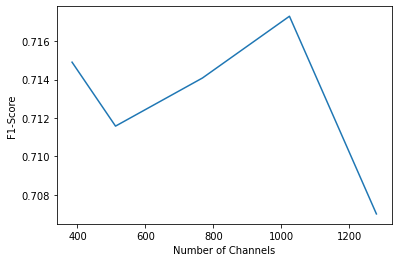

In [ ]:
import matplotlib.pyplot as plt

z_dim = 64
channels = [384, 512, 768, 1024, 1280]
final_score = [score1[1], score2[1], score3[1], score4[1], score5[1]]

plt.plot(channels, final_score)  
plt.xlabel("Number of Channels")
plt.ylabel("F1-Score")
plt.show()  